# Data preprocessing

## Downloading datasets

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2024-09-02 15:49:38--  https://storage.googleapis.com/learning-datasets/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4007:80d::201b, 2a00:1450:4007:80e::201b, 2a00:1450:4007:805::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4007:80d::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191,38M  22,1MB/s    in 13s     

2024-09-02 15:49:51 (14,9 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2024-09-02 15:49:51--  https://storage.googleapis.com/learning-datasets/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4007:80b::201b, 2a00:1450:4007:80d::201b, 2a00:1450:4007:805::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4007:80b::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## Unzipping

In [2]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# Checking in

Rocks are in the rock folder, papers in the paper one and etc so we can use Imagedatagenerator with no labels.

In [3]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock04-081.png', 'rock01-114.png', 'rock04-100.png', 'rock04-052.png', 'rock01-074.png', 'rock03-067.png', 'rock02-038.png', 'rock03-007.png', 'rock04-044.png', 'rock02-064.png']
['paper04-013.png', 'paper06-054.png', 'paper02-097.png', 'paper03-098.png', 'paper05-000.png', 'paper05-071.png', 'paper07-030.png', 'paper07-070.png', 'paper03-065.png', 'paper07-067.png']
['scissors04-055.png', 'scissors03-117.png', 'scissors03-092.png', 'scissors04-005.png', 'testscissors03-078.png', 'testscissors02-000.png', 'scissors02-033.png', 'testscissors02-018.png', 'scissors04-028.png', 'testscissors01-047.png']


# Printing datas

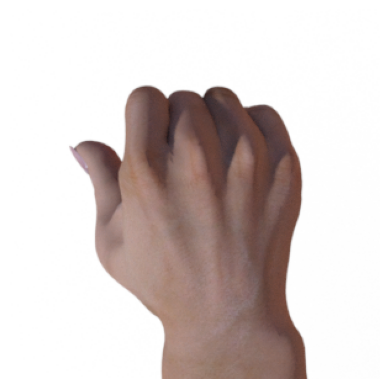

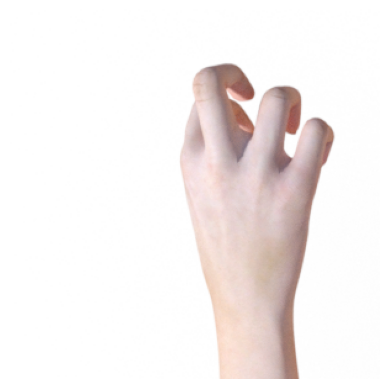

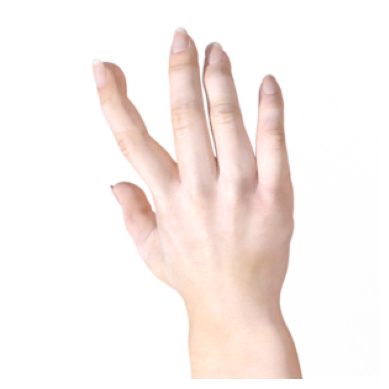

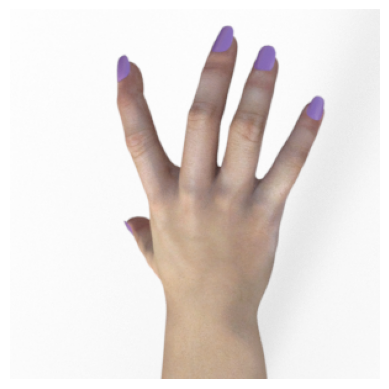

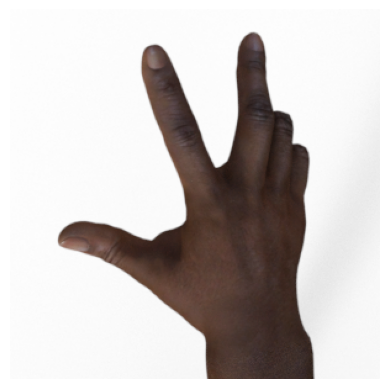

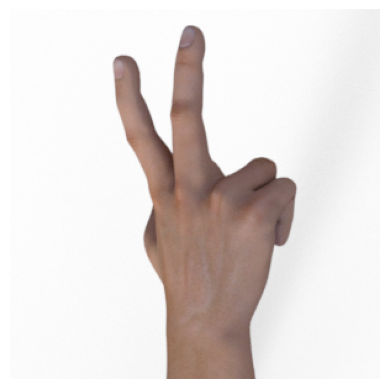

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
    for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
    for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
    for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

# ImageDataGenerator

ImageDataGenerator is used so we won't need label. Evry type of hands are in their own folder. It's used with
training_datagen.flow_from_directory to create the training data with labels from the dataset directory. We do the same thing for the validator (test) dataset.

batch_size for the number of picture to process in the same time. It's a also the number of image to process before chainging weigh in the neronal network. if it's big it goes faster, if its low the training is slower. Each have advantages and disadvantages. Different from the learning rate but close.

To avoid the over fitting, we will use the data augmentation method.The parameters of ImageDataGenerator will modify the pictures like rotate, zoom etc ..

In [6]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
# # Use this to have the over-fitting
# training_datagen = ImageDataGenerator(
#     rescale = 1./255,
# )

# Use this to avoid over fitting
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,  # rotate in 40 degre range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Creating the model

In [7]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # scond convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Dropout will eliminate certains neuron so we have better efficiency
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

/home/ange/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training

- Verbose is for the amount of information you want in console. verbose=0 is nothing etc ..
- validations steps is the number of batch evaluated after each epoch to calculate accuracy. Here is 3 and each a batch size is 126 so the validation will use 378 first picture of validation to calculate validation accuracy. f not specified, it takes all oh them
- putting steps_per_epoch = 20 is very bad here, you can try and see the accuracy.

In [23]:
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)
history = model.fit(train_generator, epochs=25, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("rps.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,946,952 (26.50 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,473,477 (13.25 MB)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8850 - loss: 0.2895 - val_accuracy: 0.9355 - val_loss: 0.1179
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9648 - loss: 0.1036
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9602 - loss: 0.1179 - val_accuracy: 0.9382 - val_loss: 0.1119
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9592 - loss: 0.1209
Epoch 5/25


2024-09-02 17:23:29.692190: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9814 - loss: 0.0689 - val_accuracy: 0.9812 - val_loss: 0.0376
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9755 - loss: 0.0603
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9565 - loss: 0.1147 - val_accuracy: 0.9704 - val_loss: 0.0718
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9795 - loss: 0.0627
Epoch 9/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9754 - loss: 0.0753 - val_accuracy: 0.9382 - val_loss: 0.1392
Epoch 10/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9774 - loss: 0.0587
Epoch 11/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9798 - loss: 0.0678 - val_accuracy: 0.9704 - val_loss: 0.0915
Epoch 12/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9801 - loss: 0.0591
Epoch 13/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9849 - loss: 0.0470 - val_accuracy: 0.9435 - val_loss: 0.1534
Epoch 14/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 58

# Plotting accuracy

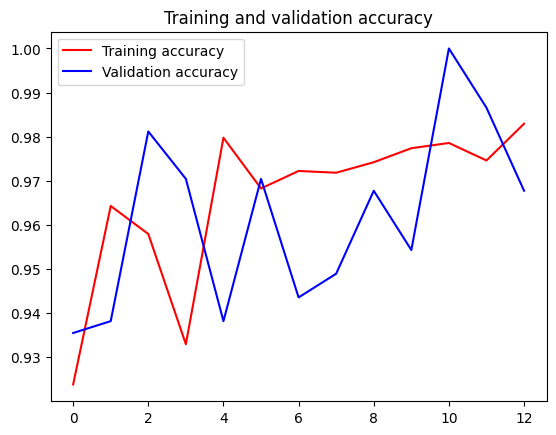

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
acc = history.history['accuracy'] # for the training accuracy during epochs
val_acc = history.history['val_accuracy'] # for the validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_acc))
# print(len(acc)) 
# print(len(val_acc))

plt.plot(epochs, acc[:len(val_acc)], 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

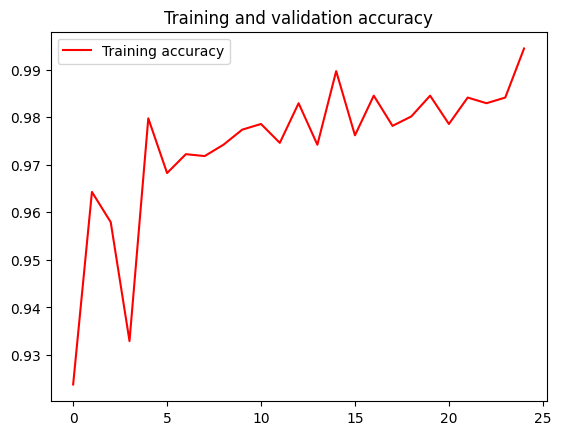

<Figure size 640x480 with 0 Axes>

In [34]:
epochs = range(len(acc))
# print(len(acc)) 
# print(len(val_acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

# Test saved model with real photos

The result is supposed to be like [% of being paper,  %of being rock, %of being scissors]

## Preparing the test functions

In [2]:
import numpy as np
from keras.preprocessing import image
import tensorflow as tf


model = tf.keras.models.load_model('rps.h5')
model.compile(optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])



def get_class(file_path): 
    img = image.load_img(file_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(file_path)
    print(classes)

# Let's test with real photos of my hand which are in the folder images

In [4]:
ciseau = 'images/ciseau.jpg'
feuille = 'images/feuille.jpg'
pierre = 'images/pierre.jpg'

file_path = feuille
get_class(file_path)
file_path = pierre
get_class(file_path)
file_path = ciseau
get_class(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
images/feuille.jpg
[[1. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
images/pierre.jpg
[[0. 1. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
images/ciseau.jpg
[[0. 0. 1.]]


In [41]:
file_path = '/home/ange/Documents/me/learningg/images/from_training/scissor.png'
get_class(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
/home/ange/Documents/me/learningg/images/from_training/scissor.png
[[0. 0. 1.]]
